# Fine-tuning timm Vision Transformers for Birds Classification


In the last notebook, we got a grasp of the attention maps with ViT ImageNet pretrained weights using the `timm` AttentionExtract utility and observed them block-by-block. In this notebook, to improve model predictions, we will fine-tune `vit_base_patch16_224` on the UCSD Caltech Birds-200 dataset. Let's examine how the fine-tuned attention map results look with the same **Myrtle Warbler** test image that we used in the last notebook.

We will keep most of the code for inference and attention visualization intact, as discussed earlier.

<img src="https://production-media.paperswithcode.com/datasets/CUB-200-2011-0000000109-6e01ce73_vMleyYb.jpeg">

## Table of Contents

* [1. Import Dependencies](#1.-Import-Dependencies)
* [2. Download the dataset](#2.-Download-the-dataset)
* [3. Training and Dataset Configurations](#3.-Training-and-Dataset-Configurations)
   
* [4. Dataset Preparation](#4.-Dataset-Preparation)
* [5. Dataloader Visualization](#5.-Dataloader-Visualization)
* [6. Helper Functions](#6.-Helper-Functions)
* [7. Model Definition](#7.-Model-Definition)
* [8. Training Step](#8.-Training-Step)
* [9. Perform Training](#9.-Perform-Training)
* [10. Inference](#10.-Inference)
* [11. Attention Map Visualization](#11.-Attention-Map-Visualization)
* [12. Conclusion](#12.-Conclusion)

### Install Packages

In [ ]:
# !pip install timm torchinfo

## 1. Import Dependencies

We shall first begin with our imports.

In [ ]:
import os
import shutil
import requests
import random
import numpy as np
import pandas as pd
from PIL import Image
from typing import Dict
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from zipfile import ZipFile, BadZipFile

from dataclasses import dataclass
from mpl_toolkits.axes_grid1 import make_axes_locatable #for colorbar handling

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torchinfo import summary

import timm
from timm.data.transforms_factory import transforms_imagenet_train
from timm.data import create_transform
from timm.utils import AttentionExtract

import warnings
warnings.filterwarnings('ignore')

bold = "\033[1m"
reset = "\033[0m"

#### Set seeds for reproducibility

In [ ]:
def seed_everything(SEED):

   random.seed(SEED)
   np.random.seed(SEED)
   torch.manual_seed(SEED)
   torch.cuda.manual_seed_all(SEED)
   torch.backends.cudnn.deterministic = True
   torch.backends.cudnn.benchmark = False

seed_everything(0)

## 2. Download the dataset

In [ ]:
def download_file(url, save_name):

    # Makes the request look like it's coming from a regular browser to avoid blocks/errors from websites
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }

    response = requests.get(url, headers = headers, stream=True)
    total_size = int(response.headers.get('content-length', 0)) #Get total number of files

    with open(save_name, 'wb') as file:
        with tqdm(total = total_size, unit='B', unit_scale = True, desc = f"Downloading: {save_name}", ascii = True) as progress_bar:
            for chunk in response.iter_content(chunk_size=1024):
                if chunk:
                    file.write(chunk)
                    progress_bar.update(len(chunk))

    print(f"Downloaded: {save_name} ✅ ")

In [ ]:
def unzip(zip_file_path):
    try:
        with ZipFile(zip_file_path, 'r') as z:
            z.extractall("./")
            print(f"Extracted: {os.path.splitext(zip_file_path)[0]}\n")
    except FileNotFoundError:
        print("File not found")
    except BadZipFile:
        print("Invalid or corrupt zip file")
    except Exception as e:
        print(f"Error occurred: {e}")

    return

In [ ]:
URL = r"https://www.dropbox.com/scl/fi/cg6wejflmorxrnzfs1v9l/UCSD_Birds_Dataset.zip?rlkey=l70aectyy2odx8qkrtbrq018x&st=cjhajeln&dl=1"

archive_name = "UCSD_Birds_Dataset"

zip_name = f"./{archive_name}.zip"

if not os.path.exists(archive_name):

    download_file(URL, zip_name)
    unzip(zip_name)

## 3. Training and Dataset Configurations

The following are the training configurations and hyperparameters, where all the images will be resized to 224, with an initial learning rate of 1e-3, and the model will be trained for 20 epochs.

In [ ]:
@dataclass
class DatasetConfig():

    root_dir = os.path.join(os.getcwd(), "UCSD_Birds_Dataset/")
    train_data_path = os.path.join(root_dir, 'CUB_200_2011/input_data/train')
    valid_data_path = os.path.join(root_dir, 'CUB_200_2011/input_data/val')
    class_names = os.path.join(root_dir, "CUB_200_2011/classes.txt")

@dataclass
class TrainingConfiguration():

    image_size = 224
    batch_size = 64 # For colab, set batch_size = 96
    num_workers = 8 # For colab set 0 workers or to try locally set 6 or 8
    lr = 0.001
    epochs = 20
    out_dir_name = 'outputs_vit_base'

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataset_config = DatasetConfig()
training_config = TrainingConfiguration()

DEVICE = training_config.device

DEVICE

device(type='cuda')

## 4. Dataset Preparation

The Caltech-UCSD Birds-200-2011 (CUB-200-2011) dataset is the most widely used dataset for fine-grained visual bird categorization tasks. It contains **11,788** images of **200** subcategories of birds (mostly North American), and the images in this dataset overlap with those in ImageNet. We have modified the dataset split of our choice instead of using the original train-validation split as outlined in the paper.

By splitting it with a validation ratio of 0.2, we will have **9414** training and **2374** validation samples.

Paper: [Link]( https://www.researchgate.net/publication/251734721_The_Caltech-UCSD_Birds200-2011_Dataset)



In [ ]:
def prepare_dataframe(file_path):

    with open(file_path, 'r') as file:
        text = file.read()

    # Process the text into a DataFrame
    data = []
    for line in text.split('\n'):
        if line.strip():
            parts = line.split(' ', 1)
            idx = int(parts[0])
            class_name = parts[1].split('.', 1)[1].replace('_', ' ')
            data.append({'idx': idx, 'class': class_name})

    df = pd.DataFrame(data)
    return df

file_path = dataset_config.class_names
class_df = prepare_dataframe(file_path)
class_df

,idx,class
0,1,Black footed Albatross
1,2,Laysan Albatross
2,3,Sooty Albatross
3,4,Groove billed Ani
4,5,Crested Auklet
...,...,...
195,196,House Wren
196,197,Marsh Wren
197,198,Rock Wren
198,199,Winter Wren


### 4.1. Preprocessing Transforms

Random data augmentations such as `HorizontalFlip`, `Rotation`, and `AdjustSharpness`, along with basic transformations like `ToTensor` and `Normalize` (using ImageNet mean and std), are applied.

In [ ]:
def train_transforms(image_size):
    """
    Returns a composed transformation pipeline for training images.
    """
    return transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(35),
        transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])

def common_transforms(image_size):
    """
    Returns a composed transformation pipeline for validation images.
    """
    return transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])

### 4.2 Dataloader

In [ ]:
train_dataset = datasets.ImageFolder(
    dataset_config.train_data_path,
    transform=(train_transforms(training_config.image_size))
)

val_dataset = datasets.ImageFolder(
    dataset_config.valid_data_path,
    transform=(common_transforms(training_config.image_size))
)

print(f"Total Training Samples: {bold} {len(train_dataset)} {reset}")
print(f"Total Val Samples: {bold} {len(val_dataset)} {reset}")

Total Training Samples:  9414 
Total Val Samples:  2374 


In [ ]:
all_classes = train_dataset.classes

print(f"No. of Classes in the dataset: {bold}{len(all_classes)} {reset}")

No. of Classes in the dataset: 200 


For efficient use of Colab's 15GB VRAM, training was conducted with a batch size of 96, utilizing approximately 11.8GB. You can adjust the training configurations based on your GPU resources.

In [ ]:
train_loader = DataLoader(
    train_dataset,
    batch_size = training_config.batch_size,
    num_workers = training_config.num_workers,
    shuffle=True
)

valid_loader = DataLoader(
    val_dataset,
    batch_size = training_config.batch_size,
    num_workers = training_config.num_workers,
    shuffle = False
)


#Santiy Check
len(next(iter(train_loader)))

2

## 5. Dataloader Visualization

Our data preparation appears to be successful, as the samples are visualized as expected.

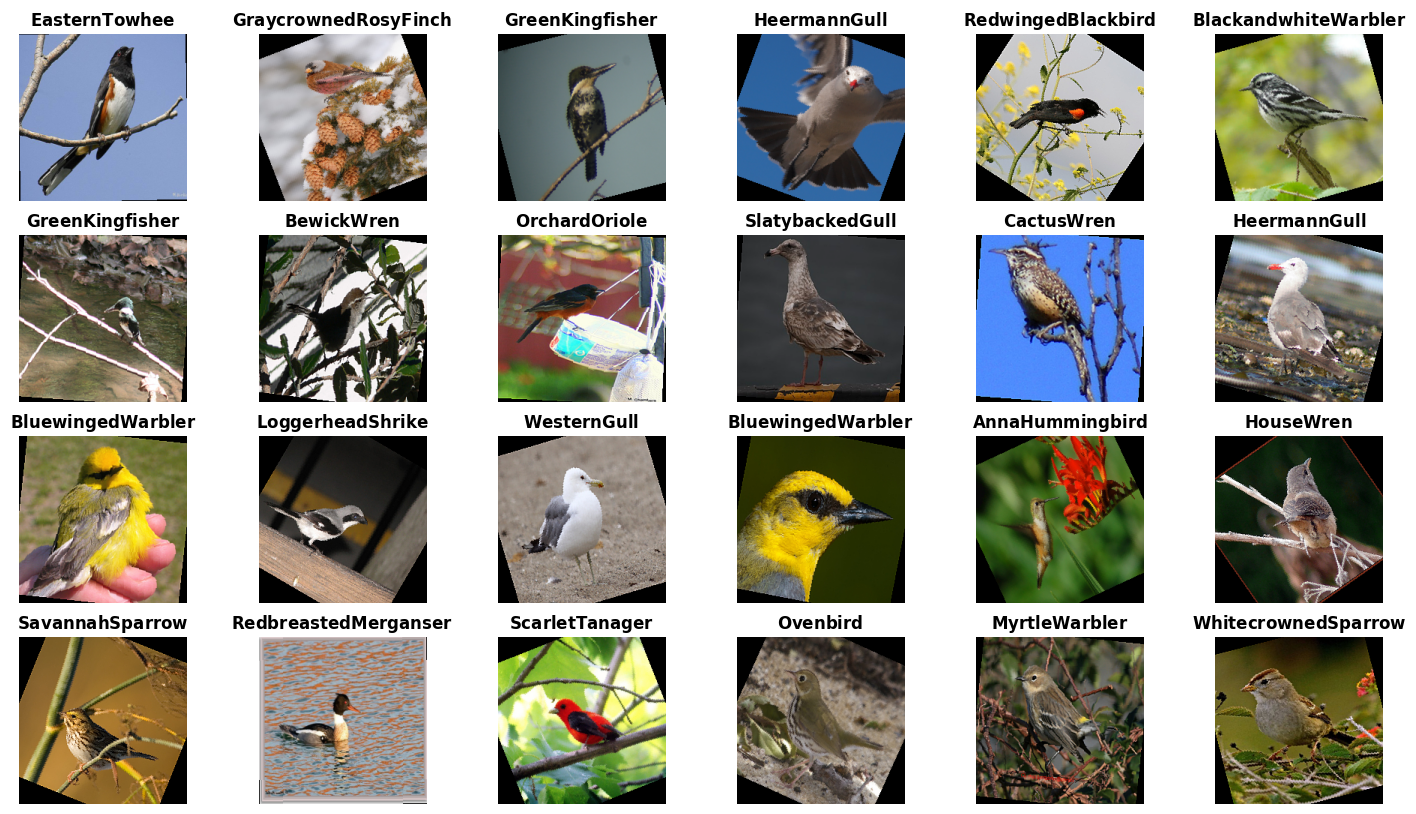

In [ ]:
class_names = train_loader.dataset.classes

mean = torch.tensor([0.485, 0.456, 0.406])
std  = torch.tensor([0.229, 0.224, 0.225])

plt.figure(figsize=(18, 10))

# Assumes dataset batch_size is at least 32.
num_rows = 4
num_cols = 6


for image_batch, labels_batch in train_loader:

    for idx in range(num_rows*num_cols):

        ax = plt.subplot(num_rows, num_cols, idx + 1)

        img_tensor_denorm = (image_batch[idx]*std[:,None,None] + mean[:,None,None]).clamp(min=0., max=1.)
        pil_image = transforms.functional.to_pil_image(img_tensor_denorm)
        plt.imshow(pil_image)
        plt.title(r"$\bf{"+class_df.loc[labels_batch[idx].item(), 'class']+"}$")
        plt.axis("off")

    break

## 6. Helper Functions

We will be defining some utilities to save the best checkpoint based on best loss and plot the loss & metric curves.

In [ ]:
def set_training_dir(dir_name=None):
    """
    This functions counts the number of training directories already present
    and creates a new one in `runs/training/`.
    And returns the directory path.
    """
    if not os.path.exists('runs/training'):
        os.makedirs('runs/training')
    if dir_name:
        new_dir_name = f"runs/training/{dir_name}"
        os.makedirs(new_dir_name, exist_ok=True)
        return new_dir_name
    else:
        num_train_dirs_present = len(os.listdir('runs/training/'))
        next_dir_num = num_train_dirs_present + 1
        new_dir_name = f"runs/training/res_{next_dir_num}"
        os.makedirs(new_dir_name, exist_ok=True)
        return new_dir_name

In [ ]:
class SaveBestModel:
    """
    Class to save the best model while training. If the current epoch's
    validation loss is lower than the previous lowest, then save the
    model state.
    """
    def __init__(
        self, best_valid_loss=float('inf')
    ):
        self.best_valid_loss = best_valid_loss

    def __call__(
        self,
        model,
        current_valid_loss,
        epoch,
        out_dir,
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss

            print(f"\nLOWEST VALIDATION LOSS: {self.best_valid_loss}")
            print(f"\nSAVING BEST MODEL ✅")

            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                }, f"{out_dir}/best_model.pth")

def save_model(out_dir, epoch, model, optimizer, criterion):
    """
    Function to save the trained model to disk.
    """
    torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, os.path.join(out_dir, 'last_model.pth'))

### 6.1 Plotting Utility

In [ ]:
plt.style.use('ggplot')

def save_loss_plot(
    out_dir,
    train_loss_list,
    valid_loss_list,
    x_label='epochs',
    y_label='train loss',
    save_name='loss'
):
    """
    Function to save both train loss graph.

    :param out_dir: Path to save the graphs.
    :param train_loss_list: List containing the training loss values.
    """
    figure_1 = plt.figure(figsize=(10, 7), num=1, clear=True)
    ax = figure_1.add_subplot()
    ax.plot(train_loss_list, color='tab:blue', label='train loss')
    ax.plot(valid_loss_list, color='tab:red', label='valid loss')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.legend()
    figure_1.savefig(f"{out_dir}/{save_name}.png")


def save_accuracy_plot(OUT_DIR, train_acc, valid_acc):
    """
    Saves the mAP@0.5 and mAP@0.5:0.95 per epoch.
    :param OUT_DIR: Path to save the graphs.
    :param map_05: List containing mAP values at 0.5 IoU.
    :param map: List containing mAP values at 0.5:0.95 IoU.
    """
    figure = plt.figure(figsize=(10, 7), num=1, clear=True)
    ax = figure.add_subplot()
    ax.plot(
        train_acc, color='tab:blue', label='train acc'
    )
    ax.plot(
        valid_acc, color='tab:red', label='valid acc'
    )
    ax.set_xlabel('Epochs')
    ax.set_ylabel('accuracy')
    ax.legend()
    figure.savefig(f"{OUT_DIR}/accuracy.png")


## 7. Model Definition

For a proper comparison, we will use the ViT base model with patch size 16 and 224 input resolution, initialized with ImageNet weights as in the previous experiment.

In [ ]:
timm.list_models(filter='vit_base_patch16*')

['vit_base_patch16_18x2_224',
 'vit_base_patch16_224',
 'vit_base_patch16_224_miil',
 'vit_base_patch16_384',
 'vit_base_patch16_clip_224',
 'vit_base_patch16_clip_384',
 'vit_base_patch16_clip_quickgelu_224',
 'vit_base_patch16_gap_224',
 'vit_base_patch16_plus_240',
 'vit_base_patch16_reg4_gap_256',
 'vit_base_patch16_rope_reg1_gap_256',
 'vit_base_patch16_rpn_224',
 'vit_base_patch16_siglip_224',
 'vit_base_patch16_siglip_256',
 'vit_base_patch16_siglip_384',
 'vit_base_patch16_siglip_512',
 'vit_base_patch16_siglip_gap_224',
 'vit_base_patch16_siglip_gap_256',
 'vit_base_patch16_siglip_gap_384',
 'vit_base_patch16_siglip_gap_512',
 'vit_base_patch16_xp_224']

In [ ]:
model_name = 'vit_base_patch16_224'

model = timm.create_model(
    model_name,
    pretrained=True,
    num_classes=len(all_classes)
)

summary(model, input_size=(1, 3, 224, 224), device = "cpu", row_settings = ["var_names"])

Layer (type (var_name))                  Output Shape              Param #
VisionTransformer (VisionTransformer)    [1, 200]                  152,064
├─PatchEmbed (patch_embed)               [1, 196, 768]             --
│    └─Conv2d (proj)                     [1, 768, 14, 14]          590,592
│    └─Identity (norm)                   [1, 196, 768]             --
├─Dropout (pos_drop)                     [1, 197, 768]             --
├─Identity (patch_drop)                  [1, 197, 768]             --
├─Identity (norm_pre)                    [1, 197, 768]             --
├─Sequential (blocks)                    [1, 197, 768]             --
│    └─Block (0)                         [1, 197, 768]             --
│    │    └─LayerNorm (norm1)            [1, 197, 768]             1,536
│    │    └─Attention (attn)             [1, 197, 768]             2,362,368
│    │    └─Identity (ls1)               [1, 197, 768]             --
│    │    └─Identity (drop_path1)        [1, 197, 768]           

In [ ]:
model = model.to(DEVICE)

model.pretrained_cfg

{'url': '',
 'hf_hub_id': 'timm/vit_base_patch16_224.augreg2_in21k_ft_in1k',
 'architecture': 'vit_base_patch16_224',
 'tag': 'augreg2_in21k_ft_in1k',
 'custom_load': False,
 'input_size': (3, 224, 224),
 'fixed_input_size': True,
 'interpolation': 'bicubic',
 'crop_pct': 0.9,
 'crop_mode': 'center',
 'mean': (0.5, 0.5, 0.5),
 'std': (0.5, 0.5, 0.5),
 'num_classes': 1000,
 'pool_size': None,
 'first_conv': 'patch_embed.proj',
 'classifier': 'head'}

---

To minimize the losses, we use an **SGD optimizer** with a momentum of `0.9`  and a CrossEntropyLoss criterion as it is a  multi-class classification task.

In [ ]:
optimizer = optim.SGD(model.parameters(), lr= training_config.lr, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# Initialize SaveBestModel class
save_best_model = SaveBestModel()

## 8. Training Step

This section implements training and validation steps for classification.

In [ ]:
def train(model, trainloader, optimizer, criterion):
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    total_batches = len(trainloader)
    total_samples = 0

    with tqdm(total=total_batches, ncols=122, desc="Train :: Epoch", leave = True) as tq:
        for i, data in enumerate(trainloader):
            image, labels = data
            batch_size = labels.size(0)
            total_samples += batch_size

            image = image.to(DEVICE)
            labels = labels.to(DEVICE)
            optimizer.zero_grad()

            # Forward pass
            outputs = model(image)
            loss = criterion(outputs, labels)
            train_running_loss += loss.item()

            # Accuracy calculation
            _, preds = torch.max(outputs.data, 1)
            train_running_correct += (preds == labels).sum().item()

            # Backpropagation and optimization
            loss.backward()
            optimizer.step()

            # Update progress bar with proper accuracy
            current_accuracy = 100. * train_running_correct / total_samples
            tq.update(1)
            tq.set_postfix(
                train_loss=f"{train_running_loss / (i + 1):.4f}",
                train_accuracy=f"{current_accuracy:.2f}%"
            )

    # Epoch loss and accuracy
    epoch_loss = train_running_loss / total_batches
    epoch_acc = 100. * train_running_correct / total_samples
    return epoch_loss, epoch_acc

In [ ]:
def validate(model, testloader, criterion):
    model.eval()
    valid_running_loss = 0.0
    valid_running_correct = 0
    total_batches = len(testloader)
    total_samples = 0

    with tqdm(total=total_batches, ncols=122, desc="Validation", leave = True) as tq:
        with torch.no_grad():
            for i, data in enumerate(testloader):
                image, labels = data
                batch_size = labels.size(0)
                total_samples += batch_size

                image = image.to(DEVICE)
                labels = labels.to(DEVICE)

                # Forward pass
                outputs = model(image)
                loss = criterion(outputs, labels)
                valid_running_loss += loss.item()

                # Accuracy calculation
                _, preds = torch.max(outputs.data, 1)
                valid_running_correct += (preds == labels).sum().item()

                # Update progress bar with proper accuracy
                current_accuracy = 100. * valid_running_correct / total_samples
                tq.update(1)
                tq.set_postfix(
                    val_loss=f"{valid_running_loss / (i + 1):.4f}",
                    val_accuracy=f"{current_accuracy:.2f}%"
                )

    # Epoch loss and accuracy
    epoch_loss = valid_running_loss / total_batches
    epoch_acc = 100. * valid_running_correct / total_samples
    return epoch_loss, epoch_acc


## 9. Perform Training



In [ ]:
# Initialize best metrics
best_train_loss = float('inf')
best_train_acc = 0
best_valid_loss = float('inf')
best_valid_acc = 0

# Lists to keep track of losses and accuracies
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []

out_dir = set_training_dir(training_config.out_dir_name)

for epoch in range(training_config.epochs):
    print(f"\n[INFO]: Epoch {epoch + 1} of {training_config.epochs}")

    # Training phase
    train_running_loss = 0.0
    train_running_correct = 0
    total_batches = len(train_loader)
    total_samples = 0  # To track the total number of samples processed

    with tqdm(total=total_batches, ncols=122, desc=f"Train :: Epoch {epoch + 1}/{training_config.epochs}", leave=True) as tq:
        for i, data in enumerate(train_loader):
            # Load data
            image, labels = data
            batch_size = labels.size(0)
            total_samples += batch_size

            image = image.to(DEVICE)
            labels = labels.to(DEVICE)
            optimizer.zero_grad()

            # Forward pass
            outputs = model(image)
            loss = criterion(outputs, labels)
            train_running_loss += loss.item()

            # Accuracy calculation
            _, preds = torch.max(outputs.data, 1)
            train_running_correct += (preds == labels).sum().item()

            # Backpropagation and optimization
            loss.backward()
            optimizer.step()

            # Update progress bar with batch metrics
            tq.update(1)
            current_accuracy = 100. * train_running_correct / total_samples
            tq.set_postfix(
                loss=f"{train_running_loss / (i + 1):.4f}",
                accuracy=f"{current_accuracy:.2f}%"
            )

    # Calculate epoch-level training metrics
    train_epoch_loss = train_running_loss / total_batches
    train_epoch_acc = 100. * train_running_correct / len(train_loader.dataset)

    # Validation phase
    valid_epoch_loss, valid_epoch_acc = validate(model, valid_loader, criterion)

    # Save the best model based on validation loss
    if valid_epoch_loss < best_valid_loss:
        best_valid_loss = valid_epoch_loss
        best_valid_acc = valid_epoch_acc
        save_best_model(model, valid_epoch_loss, epoch, out_dir)

    # Accumulate metrics for plotting later
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)

    # Save model checkpoint
    save_model(out_dir, epoch, model, optimizer, criterion)

    # Display final epoch metrics (separate from tqdm updates)
    print(f"Training Loss: {train_epoch_loss:.4f}, Training Acc: {train_epoch_acc:.2f}%")
    print(f"Validation Loss: {valid_epoch_loss:.4f}, Validation Acc: {valid_epoch_acc:.2f}%")
    print('-' * 50)

print(f'{bold}TRAINING COMPLETE{reset}')
print(f"Best Validation Loss: {best_valid_loss:.4f}, Best Validation Accuracy: {best_valid_acc:.2f}%")



[INFO]: Epoch 1 of 20


Validation: 100%|███████████████████████████████████| 38/38 [00:06<00:00,  6.30it/s, val_accuracy=73.34%, val_loss=0.9130]



LOWEST VALIDATION LOSS: 0.9130027615710309

SAVING BEST MODEL ✅
Training Loss: 2.7903, Training Acc: 39.41%
Validation Loss: 0.9130, Validation Acc: 73.34%
--------------------------------------------------

[INFO]: Epoch 2 of 20


Validation: 100%|███████████████████████████████████| 38/38 [00:06<00:00,  6.25it/s, val_accuracy=79.06%, val_loss=0.7250]



LOWEST VALIDATION LOSS: 0.7249581580981612

SAVING BEST MODEL ✅
Training Loss: 0.7033, Training Acc: 80.02%
Validation Loss: 0.7250, Validation Acc: 79.06%
--------------------------------------------------

[INFO]: Epoch 3 of 20


Validation: 100%|███████████████████████████████████| 38/38 [00:06<00:00,  6.27it/s, val_accuracy=81.04%, val_loss=0.6849]



LOWEST VALIDATION LOSS: 0.6848721217952276

SAVING BEST MODEL ✅
Training Loss: 0.4223, Training Acc: 87.59%
Validation Loss: 0.6849, Validation Acc: 81.04%
--------------------------------------------------

[INFO]: Epoch 4 of 20


Validation: 100%|███████████████████████████████████| 38/38 [00:06<00:00,  6.28it/s, val_accuracy=81.42%, val_loss=0.6266]



LOWEST VALIDATION LOSS: 0.6265831840543175

SAVING BEST MODEL ✅
Training Loss: 0.2876, Training Acc: 91.68%
Validation Loss: 0.6266, Validation Acc: 81.42%
--------------------------------------------------

[INFO]: Epoch 5 of 20


Validation: 100%|███████████████████████████████████| 38/38 [00:05<00:00,  6.38it/s, val_accuracy=83.91%, val_loss=0.5848]



LOWEST VALIDATION LOSS: 0.5848345949290026

SAVING BEST MODEL ✅
Training Loss: 0.1941, Training Acc: 94.83%
Validation Loss: 0.5848, Validation Acc: 83.91%
--------------------------------------------------

[INFO]: Epoch 6 of 20


Validation: 100%|███████████████████████████████████| 38/38 [00:05<00:00,  6.39it/s, val_accuracy=83.66%, val_loss=0.5933]


Training Loss: 0.1124, Training Acc: 97.13%
Validation Loss: 0.5933, Validation Acc: 83.66%
--------------------------------------------------

[INFO]: Epoch 7 of 20


Validation: 100%|███████████████████████████████████| 38/38 [00:05<00:00,  6.39it/s, val_accuracy=85.05%, val_loss=0.5747]



LOWEST VALIDATION LOSS: 0.5746619632149017

SAVING BEST MODEL ✅
Training Loss: 0.0753, Training Acc: 98.53%
Validation Loss: 0.5747, Validation Acc: 85.05%
--------------------------------------------------

[INFO]: Epoch 8 of 20


Validation: 100%|███████████████████████████████████| 38/38 [00:05<00:00,  6.37it/s, val_accuracy=85.09%, val_loss=0.5774]


Training Loss: 0.0490, Training Acc: 99.24%
Validation Loss: 0.5774, Validation Acc: 85.09%
--------------------------------------------------

[INFO]: Epoch 9 of 20


Validation: 100%|███████████████████████████████████| 38/38 [00:05<00:00,  6.37it/s, val_accuracy=85.80%, val_loss=0.5547]



LOWEST VALIDATION LOSS: 0.5547366780351455

SAVING BEST MODEL ✅
Training Loss: 0.0371, Training Acc: 99.41%
Validation Loss: 0.5547, Validation Acc: 85.80%
--------------------------------------------------

[INFO]: Epoch 10 of 20


Validation: 100%|███████████████████████████████████| 38/38 [00:05<00:00,  6.39it/s, val_accuracy=85.72%, val_loss=0.5576]


Training Loss: 0.0265, Training Acc: 99.72%
Validation Loss: 0.5576, Validation Acc: 85.72%
--------------------------------------------------

[INFO]: Epoch 11 of 20


Validation: 100%|███████████████████████████████████| 38/38 [00:05<00:00,  6.40it/s, val_accuracy=86.18%, val_loss=0.5593]


Training Loss: 0.0185, Training Acc: 99.89%
Validation Loss: 0.5593, Validation Acc: 86.18%
--------------------------------------------------

[INFO]: Epoch 12 of 20


Validation: 100%|███████████████████████████████████| 38/38 [00:05<00:00,  6.37it/s, val_accuracy=85.68%, val_loss=0.5622]


Training Loss: 0.0158, Training Acc: 99.89%
Validation Loss: 0.5622, Validation Acc: 85.68%
--------------------------------------------------

[INFO]: Epoch 13 of 20


Validation: 100%|███████████████████████████████████| 38/38 [00:05<00:00,  6.37it/s, val_accuracy=86.56%, val_loss=0.5590]


Training Loss: 0.0132, Training Acc: 99.93%
Validation Loss: 0.5590, Validation Acc: 86.56%
--------------------------------------------------

[INFO]: Epoch 14 of 20


Validation: 100%|███████████████████████████████████| 38/38 [00:05<00:00,  6.38it/s, val_accuracy=85.93%, val_loss=0.5709]


Training Loss: 0.0149, Training Acc: 99.87%
Validation Loss: 0.5709, Validation Acc: 85.93%
--------------------------------------------------

[INFO]: Epoch 15 of 20


Validation: 100%|███████████████████████████████████| 38/38 [00:05<00:00,  6.38it/s, val_accuracy=85.93%, val_loss=0.5674]


Training Loss: 0.0101, Training Acc: 99.93%
Validation Loss: 0.5674, Validation Acc: 85.93%
--------------------------------------------------

[INFO]: Epoch 16 of 20


Validation: 100%|███████████████████████████████████| 38/38 [00:05<00:00,  6.39it/s, val_accuracy=86.65%, val_loss=0.5618]


Training Loss: 0.0082, Training Acc: 99.98%
Validation Loss: 0.5618, Validation Acc: 86.65%
--------------------------------------------------

[INFO]: Epoch 17 of 20


Validation: 100%|███████████████████████████████████| 38/38 [00:05<00:00,  6.37it/s, val_accuracy=86.52%, val_loss=0.5663]


Training Loss: 0.0071, Training Acc: 99.99%
Validation Loss: 0.5663, Validation Acc: 86.52%
--------------------------------------------------

[INFO]: Epoch 18 of 20


Validation: 100%|███████████████████████████████████| 38/38 [00:05<00:00,  6.38it/s, val_accuracy=86.82%, val_loss=0.5630]


Training Loss: 0.0064, Training Acc: 99.99%
Validation Loss: 0.5630, Validation Acc: 86.82%
--------------------------------------------------

[INFO]: Epoch 19 of 20


Validation: 100%|███████████████████████████████████| 38/38 [00:05<00:00,  6.38it/s, val_accuracy=86.44%, val_loss=0.5713]


Training Loss: 0.0057, Training Acc: 99.99%
Validation Loss: 0.5713, Validation Acc: 86.44%
--------------------------------------------------

[INFO]: Epoch 20 of 20


Validation: 100%|███████████████████████████████████| 38/38 [00:05<00:00,  6.38it/s, val_accuracy=86.31%, val_loss=0.5685]


Training Loss: 0.0052, Training Acc: 100.00%
Validation Loss: 0.5685, Validation Acc: 86.31%
--------------------------------------------------
TRAINING COMPLETE
Best Validation Loss: 0.5547, Best Validation Accuracy: 85.80%


---

After training for 20 epochs, the checkpoint saved after the 9th epoch was identified as the best model, with a validation accuracy of **85.8%**. However we also, saved the last epoch checkpoint.

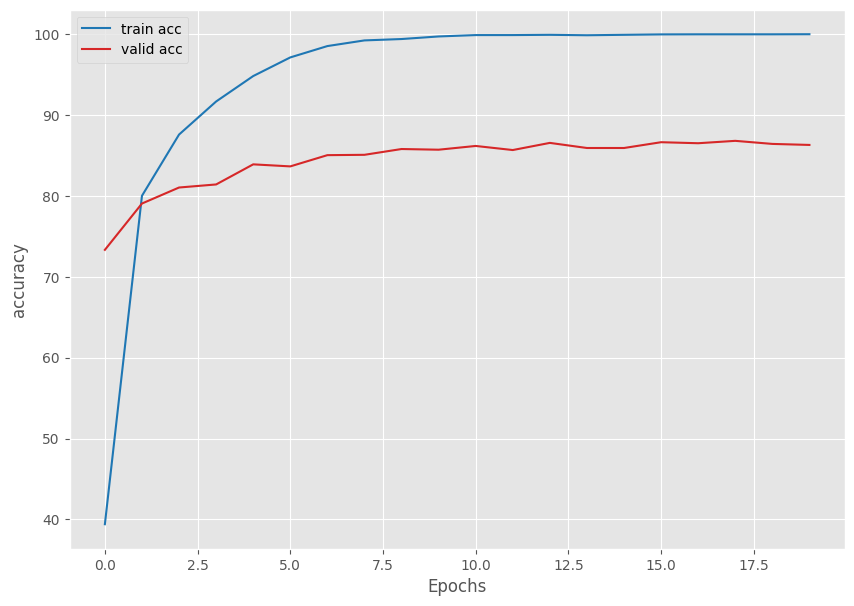

In [ ]:
# Plotting loss and accuracy curves in a separate cell.
save_loss_plot(out_dir, train_loss, valid_loss)
save_accuracy_plot(out_dir, train_acc, valid_acc)

## 10. Inference

Load the best checkpoint

In [ ]:
ckpt_path = "runs/training/outputs_vit_base/best_model.pth"

timm.layers.set_fused_attn(False)

trained_model = timm.create_model(
    model_name,
    pretrained=False,
    num_classes=len(all_classes)
)

In [ ]:
# Load the checkpoint
checkpoint = torch.load(ckpt_path, map_location=DEVICE)
checkpoint_state_dict = checkpoint["model_state_dict"]

# Compare keys
model_keys = set(trained_model.state_dict().keys())
checkpoint_keys = set(checkpoint_state_dict.keys())

if model_keys == checkpoint_keys:
    print(f"{bold}All keys matched ✅ {reset}")
else:
    print(f"{bold}Checkpoint Loaded ⚠️ Keys mismatch ❌{reset}")

# Load the state_dict into the model
trained_model.load_state_dict(checkpoint_state_dict, strict=False)

trained_model = trained_model.to(DEVICE).eval()

All keys matched ✅ 


### 10.1 Preprocess Test Image

In [ ]:
URL = "https://learnopencv.com/wp-content/uploads/2024/11/myrtle_warbler_01.jpg"
save_name = 'warbler.jpg'

download_file(URL, save_name)


URL = "https://learnopencv.com/wp-content/uploads/2024/11/attention_map_vit_base.png"
save_name = 'attention_map_imagenet.png'

download_file(URL, save_name)

Downloading: warbler.jpg:   0%|          | 0.00/19.1k [00:00<?, ?B/s]

Downloaded: warbler.jpg ✅ 


Downloading: attention_map_imagenet.png:   0%|          | 0.00/505k [00:00<?, ?B/s]

Downloaded: attention_map_imagenet.png ✅ 


---

Orig Img Shape (700, 400)


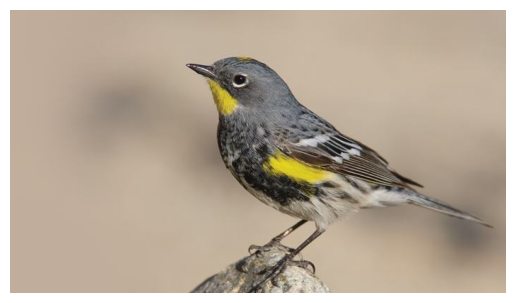

In [ ]:
img_path = 'warbler.jpg'
image_size = 224 #input size expected by model

img = Image.open(img_path).convert("RGB")

print("Orig Img Shape", img.size)

plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
def denormalize(tensor, mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]):
    mean = torch.tensor(mean).view(3,1,1) #(3,) --> (3,H,W)
    std = torch.tensor(std).view(3,1,1)
    return (tensor * std + mean)

### 10.2 Prediction

In [ ]:
transformed_img  = common_transforms(image_size)(img)

# transformed_img = denormalize(transformed_img).clip(0,1)

# # Convert the normalized image to a PyTorch tensor
ip_img = transformed_img.unsqueeze(0).to(DEVICE)
# print(ip_img.shape)

with torch.no_grad():
    predictions = trained_model.to(DEVICE)(ip_img)

print(predictions.shape)

torch.Size([1, 200])


In [ ]:
softmax = nn.Softmax(dim=1)
probs = softmax(predictions)
print(probs.shape)

torch.Size([1, 200])


The predictions are on point, correctly identifying the bird class as Myrtle Warbler.

In [ ]:
result = class_df.iloc[np.argmax(probs[0].detach().cpu().numpy())]
print(f"idx: {bold}{result['idx']}{reset} \nClass: {bold}{result['class']}{reset}")

idx: 171 
Class: Myrtle Warbler


## 11. Attention Map Visualization

In [ ]:
extractor = AttentionExtract(trained_model, method='fx') #feature extractor

In [ ]:
def process_image(
    image: Image.Image,
    model: torch.nn.Module,
    extractor: AttentionExtract
) -> Dict[str, torch.tensor]:

    """Process the input image and get the attention map"""

    #Get correct transform for the model

    config = model.pretrained_cfg

    transform = create_transform(
        input_size = config['input_size'], #default: (224, 224)
        crop_pct = config['crop_pct'],     #default: no cropping
        mean = config['mean'],
        std = config['std'],
        interpolation = config['interpolation'], #default: bilinear
        is_training = False
    )

    #Preprocess the image
    tensor = transform(image).unsqueeze(0).to(DEVICE) #add batch

    #Extract the attention maps
    attention_maps = extractor(tensor)

    return attention_maps

In [ ]:
attention_maps = process_image(img, trained_model, extractor)

print(attention_maps.keys())

dict_keys(['blocks.0.attn.softmax', 'blocks.1.attn.softmax', 'blocks.2.attn.softmax', 'blocks.3.attn.softmax', 'blocks.4.attn.softmax', 'blocks.5.attn.softmax', 'blocks.6.attn.softmax', 'blocks.7.attn.softmax', 'blocks.8.attn.softmax', 'blocks.9.attn.softmax', 'blocks.10.attn.softmax', 'blocks.11.attn.softmax'])


In [ ]:
num_prefix_tokens = getattr(model, 'num_prefix_tokens', 1) ## Default to single class token [CLS] if not specified

head_fusion = 'mean'

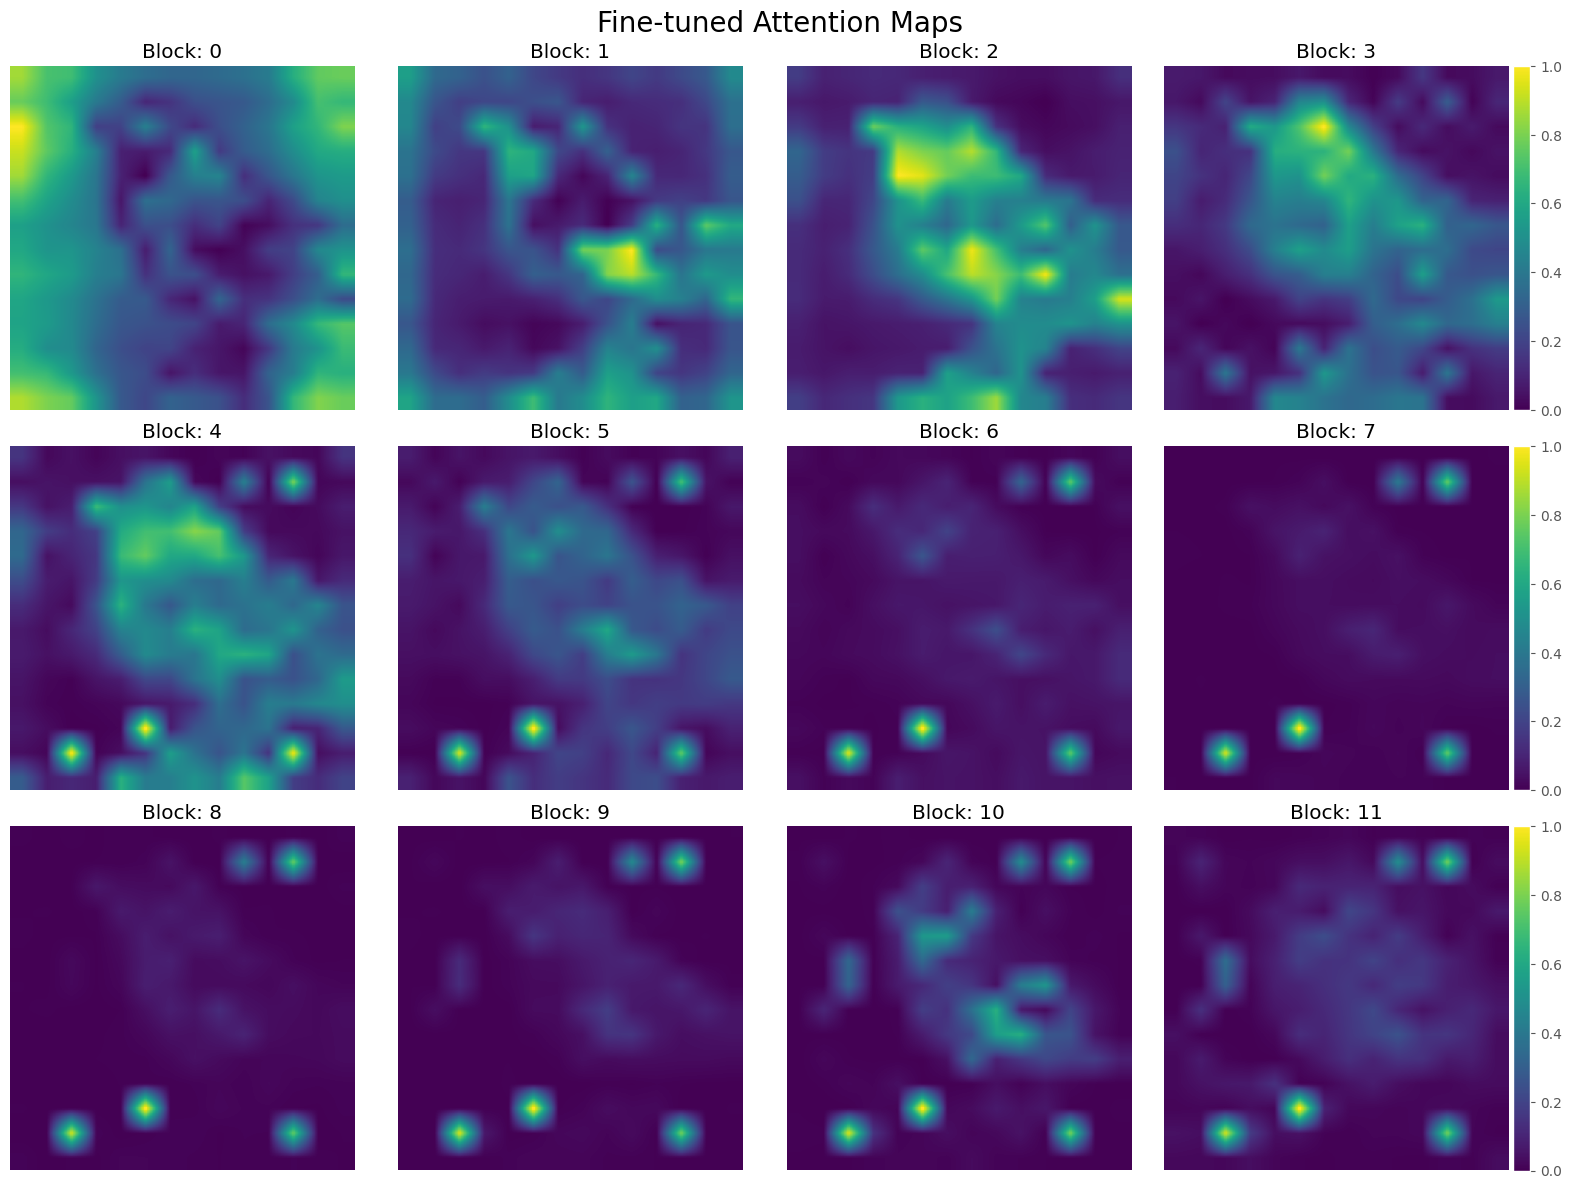

In [ ]:
fig, axes = plt.subplots(3, 4, figsize = (16, 12)) #Create a 3x4 grid of subplots
fig.suptitle(f"Fine-tuned Attention Maps", fontsize = (20))
axes = axes.flatten() # Flatten the 2D array of subplots into a 1D array

for i, (layer_name, attn_map) in enumerate(attention_maps.items()):

    attn_map = attn_map[0] #Remove batch dimension; [num_heads, num_patches, num_patches]

    attn_map = attn_map[:, :, num_prefix_tokens:] #Remove prefix tokens [CLS] for visualization

    if head_fusion  == "mean":
        attn_map = attn_map.mean(0) #along the [num_heads, num_patches, num_patches - 1]

    else:
        raise ValueError(f"Invalid head fusion method: {head_fusion}")

    # Use the class token's attention
    attn_map = attn_map[0]

    #Reshape the attention map to 2D
    num_patches = int(attn_map.shape[0] ** 0.5) #to avoid negative values
    attn_map = attn_map.reshape(num_patches, num_patches)

    #Interpolate to match image size
    attn_map = attn_map.unsqueeze(0).unsqueeze(0)

    # Comment the line below, if you like to visualize attention maps without any smoothening effect.
    # which would look similar to the feature image shown in this notebook.
    attn_map = F.interpolate(attn_map, size = (ip_img.shape[2], ip_img.shape[2]), mode = 'bilinear', align_corners = False)

    attn_map = attn_map.squeeze().detach().cpu().numpy()

    #Normalize attention map
    attn_map = (attn_map - attn_map.min()) / (attn_map.max() - attn_map.min())

    ax = axes[i]
    im = ax.imshow(attn_map, cmap = 'viridis')
    ax.set_title(f'Block: {i}')
    ax.axis('off')

    #add colorbar only to last subplot
    if (i + 1) % 4 == 0:  # Check if it's the last subplot in a row
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(im, cax=cax)

plt.tight_layout()
plt.show()

### 11.1 Attention Comparison of Fine-tuned `vit_base_p16_224` v/s ImageNet Pretrained `vit_base_p16_224`

Let's compare the attention maps of the ImageNet pretrained weights from the previous notebook with the above fine-tuned ViT model.

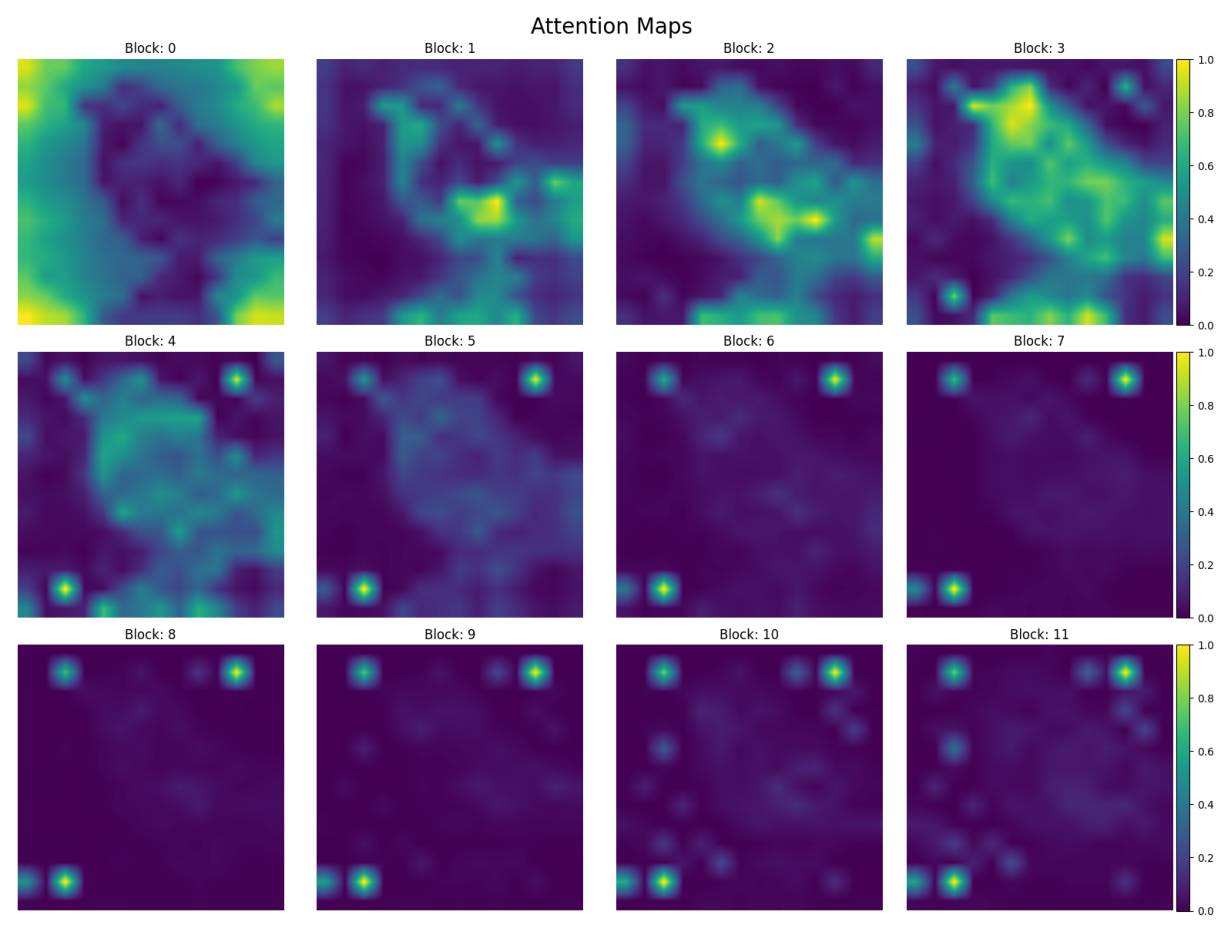

In [ ]:
attn_path = 'attention_map_imagenet.png'

attn_img = Image.open(attn_path).convert("RGB")

width, height = attn_img.size

plt.figure(figsize = (width / 100, height/100))
plt.imshow(attn_img)
plt.axis('off')
plt.show()

Fine-tuning on the UCSD bird dataset has led the ViT model to develop attention patterns that emphasize specific details critical for fine-grained distinctions. This fine-tuning process has enabled the model to better learn representations and highlight the discriminative features necessary for precise bird classification.

While in some scenarios the attention patterns may seem similar, the fine-tuned model's attention is more confident and focused in specific areas:

1. **(Blocks 0-3)**  
   In the first few layers, the fine-tuned model quickly starts focusing on key parts of the bird, such as the head, eye, and body outline. Unlike the ImageNet-pretrained model, which spreads its attention across larger, less relevant areas, the fine-tuned model narrows its focus early on, filtering out unnecessary background details. This early targeting lays the groundwork for identifying finer details in subsequent layers.

2. **(Blocks 4-7)**  
   In the middle layers, the fine-tuned model sharpens its attention, capturing distinctive features like wing patterns, subtle markings on the plumage, and the overall shape of the bird. These layers also start emphasizing species-specific details, which are crucial for distinguishing birds that look very similar. In contrast, the pretrained model continues to show broader attention, making it less specialized at this stage.

3. **(Blocks 8-11)**  
   By the final layers, the fine-tuned model hones in on highly discriminative features, such as unique color patterns, fine structural details, and the contours of specific body parts. This precise focus allows the model to capture subtle differences critical for accurate classification, like the arrangement of feathers or unique markings. The pretrained model, however, still displays a more general attention pattern, limiting its effectiveness for tasks requiring fine-grained distinctions.


## 12. Conclusion

To conclude, fine-tuning ViT on domain-specific tasks has demonstrated improved results, highlighting its adaptability and enhanced performance in specialized classification tasks. Moving forward, we will explore some breakthrough ViT derivatives, such as CLIP, to understand their advancements and applications.

### References



* [HuggingFace Blog](https://huggingface.co/blog/fine-tune-vit)
* [Fine-tune ViT Tutorial Notebook](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/VisionTransformer/Fine_tuning_the_Vision_Transformer_on_CIFAR_10_with_the_%F0%9F%A4%97_Trainer.ipynb)